# Creating a NeuralNetwork from scratch
> A tutorial to code a neural network from scratch in python using numpy.

- toc: false
- badges: true
- comments: true
- categories: [deeplearning python3.x numpy]
- image: images/backprop.jpeg

I will assume that you all know what a artificial neural network is and have a little bit of knowledge about `forward and backward propagation`. Just having a simple idea is enough.

If you do not know what the above terms are or would like to brush up on the topics , I would suggest this amazing [youtube playlist by 3Blue1Brown](https://www.youtube.com/watch?v=aircAruvnKk&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi).

> youtube: https://www.youtube.com/watch?v=aircAruvnKk&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi

## Setting up Imports:

In [1]:
import numpy as np
import gzip
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import warnings


np.random.seed(123)
%matplotlib inline
warnings.filterwarnings("ignore")

## Preparing the data

For this blog post, we'll use one of the most famous datasets in computer vision, [MNIST](https://en.wikipedia.org/wiki/MNIST_database). MNIST contains images of handwritten digits, collected by the National Institute of Standards and Technology and collated into a machine learning dataset by Yann Lecun and his colleagues. Lecun used MNIST in 1998 in [Lenet-5](http://yann.lecun.com/exdb/lenet/), the first computer system to demonstrate practically useful recognition of handwritten digit sequences. This was one of the most important breakthroughs in the history of AI.

Run the code below to download the `MNIST` dataset. The dataset will be downloaded to the path `../../Datasets/` or you can modify the path as you like.

In [2]:
#hide_output
!wget -P "../../Datasets/" http://deeplearning.net/data/mnist/mnist.pkl.gz

--2020-09-23 02:28:42--  http://deeplearning.net/data/mnist/mnist.pkl.gz
Resolving deeplearning.net (deeplearning.net)... 132.204.26.28
Connecting to deeplearning.net (deeplearning.net)|132.204.26.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16168813 (15M) [application/x-gzip]
Saving to: ‘../../Datasets/mnist.pkl.gz.2’

mnist.pkl.gz.2      100%[===================>]  15.42M  1.26MB/s    in 14s     

2020-09-23 02:28:57 (1.11 MB/s) - ‘../../Datasets/mnist.pkl.gz.2’ saved [16168813/16168813]



In [5]:
def get_data(path):
    """
    Fn to unzip the MNIST data and return
    the data as numpy arrays
    """
    with gzip.open(path, 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    return map(np.array, (x_train,y_train,x_valid,y_valid))


x_train,y_train,x_valid,y_valid = get_data(path= "../../Datasets/mnist.pkl.gz")

tots,feats = x_train.shape
print("Shape of x_train:",x_train.shape)
print("Total number of examples:", tots)
print("Number of pixel values per image:", feats)

Shape of x_train: (50000, 784)
Total number of examples: 50000
Number of pixel values per image: 784


To make our life a bit easier we are going to take only the examples that contain a 1 or 0.

In [6]:
zero_mask = [y_train==0] # grab all the index values where 0 is present
one_mask = [y_train==1] # grad all the index valus where 1 is present

# grab all the 1's and 0's and make training set
x_train = np.vstack((x_train[zero_mask], x_train[one_mask]))
y_train = np.reshape(y_train, (-1,1))
y_train = np.squeeze(np.vstack((y_train[zero_mask], y_train[one_mask])))

x_train.shape, y_train.shape

((10610, 784), (10610,))

Hence, now our training set has 10610 examples

Let's view some example images from our dataset:

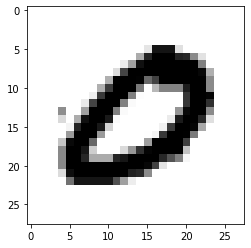

In [8]:
#collapse 
plt.imshow(x_train[50].reshape(28,28), cmap="binary");

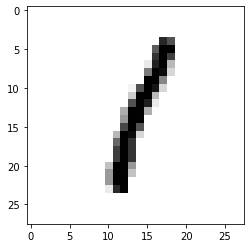

In [9]:
#collapse
plt.imshow(x_train[5000].reshape(28,28), cmap="binary");

## Basic Model Architecture

For this task we are going to use a very basic model architecture this 2 linear layers and a output layer with 10 outputs.

In [10]:
#collapse 
import graphviz
def gv(s): return graphviz.Source('digraph G{ rankdir="LR"' + s + '; }')

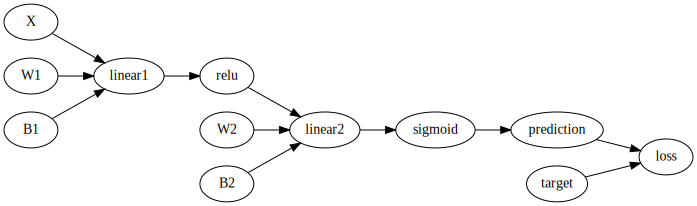

In [11]:
#collapse
gv('''
X->linear1->relu->linear2->sigmoid->prediction->loss
W1->linear1
B1->linear1
W2->linear2
B2->linear2
target->loss
''')

## Let's take a deep dive into what this network means:

Let's take at look at all the individual components of this network:
- **Linear:**
  The linear layer computes the following :      
   ```
   out = matmul(input,W1) + B1
   ```
   
- **ReLU:** 
  The relu computes the following:
  ```
  out = max(0, input)
  ```
- **Sigmoid:** 
  The sigmoid computes the following:
  ```
  out = 1/(1 + e.pow(input))
  ```
  
- **Loss:** 
  For the loss we are going to use the CrossEntropy Loss which is defined by the follwoing equation:
  $$loss= -\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(yhat^{(i)}\right) + (1-y^{(i)})\log\left(1-yhat^{(i)}\right)) $$

**Now that we have our model architecture, let's create the different parts needed to assemble the model:**
- linear layer
- relu activation
- sigmoid activation
- loss

The `Backward` pass of out model would look something like this:

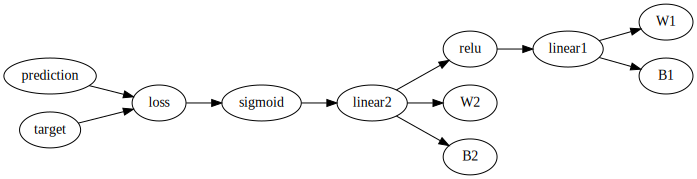

In [12]:
#collapse
gv('''
prediction->loss
loss->sigmoid
sigmoid->linear2
linear2->relu
relu->linear1
linear2->W2
linear2->B2
linear1->W1
linear1->B1
target->loss
''')

**Let's first try to make some sense of what is happening in the backward and forward pass of our model:**

On paper our forward pass would look like this is pseudo-code:
    
```python
inputs = x # original inputs
targets = y # original targets

z1 = inputs @ w2 + b2
a1 = relu(z1)

z2 = a1 @ w2 + b2
a2 = sigmoid(z2) # this is our model prediction

loss = loss_fn(a2, targets)
```

Consequently our backward pass in psuedo code would be something like this :  

(Let us assume that the `grad(inp, out)` computes the gradients of `inp` wrt `out`)

```python
# gradient of loss wrt output of the previous activation layer
da2 = grad(loss, a2) 

# gradient of loss wrt to z2
dz2 = grad(loss, z2) = grad(loss, a2) * grad(a2,z2) 

# gradient of the loss wrt to weight w2: [current layer]
dw2 = grad(loss, w2) = grad(loss, z2) * grad(z2, w2) = dz2 * grad(z2, w2)
# gradient of the loss wrt to bias b2: [current layer]
db2 = grad(loss, b2) = grad(loss, z2) * grad(z2, b2) = dz2 * grad(z2, b2)
# gradient of loss wrt a1: [previous layer]
da1 = grad(loss, a1) = grad(loss, z2) * grad(z2, a1) = dz2 * grad(z2, a1)

# gradient of loss wrt z1
dz1 = grad(loss, z1) = grad(loss, a1) * grad(a1, z1) = da1 * grad(a1, z1)

# gradient of the loss wrt to weight w1: [current layer]
dw1 = grad(loss, w1) = grad(loss, z1) * grad(z1, w1) = dz1 * grad(z1, w1)
# gradient of the loss wrt to bias b1: [current layer]
db1 = grad(loss, b1) = grad(loss, z1) * grad(z1, b1) = dz1 * grad(z1, b1)
# gradient of the loss wrt to a0: [previous layer]
da0 = grad(loss, a0) = grad(loss, z1) * grad(z1, a0) = dz2 * grad(z1, a0)


# Update parameters :
# since we now have all the required gradients we can now perform the update step
w1 -= learning_rate * dw1
b1 -= learning_rate * db1

w2 -= learning_rate * dw2
b2 -= learning_rate * db2
```

### The Linear Layer

Below code creates a `Linear class` which represents a `Linear` layer in out neural-network. The `forward function` of the class implements the of the `layer's forward propagation` & the `backward function` implements the `layers's backward propagation`. Let's go to detail into what the code means:

- **forward:**  
This part is quite straight-forward it computes the dot-product between the `input` and the `weights` & adds the `bias` term to get `z`. It also stores all the intermidiate values generated to use in the backward pass.

- **backward:**  
This part is a bit complicated. Let's go through this: 
 - The backward method of the class `Linear` takes in the argument `grads`. 
 - `grads` is the gradient of the loss wrt to the output of the current linear layer ie., `dz` if we were to follow the noencalature of our pseudo-code.

In [ ]:
class Linear:
    def __init__(self, w, b):
        self.w = w
        self.b = b
        
    def forward(self, inp):
        """
        Implement the linear part of a layer's forward propagation.
        Args:
        -----
            inp : activations from previous layer (or input data)
        Returns:
        -------
            Z  : the input of the activation function, also called pre-activation parameter 
        """
        self.inp = inp
        self.z   = inp @ self.w + self.b
        return self.z
    
    def backward(self, grads):
        """
        Implement the linear portion of backward propagation for a single layer.

        Args:
        ----
            grads :  Gradient of the cost with respect to the linear output. 
                     or the accumulated gradients from the prev layers. 
                     This is used for the chain rule to compute the gradients.
        Returns:
        -------
            da : Gradient of cost wrt to the the input of the current layer ie.,
                 the activations fro the previous layer.
            dw : Gradient of the cost with respect to W
            db : Gradient of the cost with respect to b
        """
        m = self.inp.shape[1]
        # gradient of loss wrt to the weights
        dw = 1/m * (self.inp.T @ grads)
        # gradient of the loss wrt to the bias
        db = 1/m * np.sum(grads, axis=1, keepdims=True)
        # gradient of the loss wrt to the input of the linear layer
        # this is used to continue the chain rule
        da = grads @ self.w.T 
        return (dz, dw, db)

### The ReLU Layer:

In [20]:
class RelU:
    def forward(self, inp):
        """
        Implement the RELU function.

        Arguments:
            inp : Output of the linear layer, of any shape

        Returns:
            output: Post-activation parameter, of the same shape as Z
        """
        self.inp = inp
        self.output = np.maximum(0, self.inp)
        return self.output
    
    def backward(self, grads):
        """
        Implement the backward propagation for a single RELU unit.

        Arguments:
            grads : post-activation gradient, of any shape

        Returns:
            dZ : Gradient of the cost with respect to Z
        """
        dz = np.array(grads, copy=True)
        dz[self.inp <= 0] = 0
        return dz